# Investigating bot statistics

## Download or load data

Here download a new dataset if desired or load an already downloaded one

### Downloading data:

In [2]:
# We don't want to exceed the max limit of bot checks
# So give it here and stop running if it is reached
botometer_max_limit = 600
bot_check_count = 0

In [3]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
from tqdm import tqdm

In [4]:
# Just pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/var/folders/hx/0dxb0wn51wx5pscstjkwf2gc000qqf/T/ipykernel_1425/1119663756.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [5]:
# A function to create a pair of lists for days to search
def create_date_lists(since_initial, until_final):
    """
    Creates a a pair of lists for since and until dates of the form
    since_list = ['2022-02-24', '2022-02-25', '2022-02-26']
    until_list = ['2022-02-25', '2022-02-26', '2022-02-27']
    """
    import datetime

    diff = datetime.datetime.strptime(until_final, "%Y-%m-%d") - datetime.datetime.strptime(since_initial, "%Y-%m-%d")
    diff = diff.days

    since_initial_datetime = datetime.datetime.strptime(since_initial, "%Y-%m-%d")
    until_initial_datetime = since_initial_datetime + datetime.timedelta(days=1)
    until_initial_datetime = datetime.datetime.strftime(until_initial_datetime, "%Y-%m-%d")

    diff = datetime.datetime.strptime(until_final, "%Y-%m-%d") - datetime.datetime.strptime(since_initial, "%Y-%m-%d")
    diff = diff.days

    since_list = []
    until_list = []
    for day in range(diff):
        since_plus_day = since_initial_datetime + datetime.timedelta(days=day)
        since_plus_day = datetime.datetime.strftime(since_plus_day, "%Y-%m-%d")
        since_list.append(since_plus_day)

        until_plus_day = since_initial_datetime + datetime.timedelta(days=day+1)
        until_plus_day = datetime.datetime.strftime(until_plus_day, "%Y-%m-%d")
        until_list.append(until_plus_day)
        
    return since_list, until_list

### Optional: get the user creation date with tweepy

In [ ]:
import json

# Load my API keys
with open("../twitter_keys_config.json") as twitter_cfg_file:
    twitter_config = json.load(twitter_cfg_file)

consumer_key = twitter_config["API_key"]
consumer_secret = twitter_config["API_secret"]
access_token = twitter_config["access_token"]
access_token_secret = twitter_config["access_secret"]

# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

# set access to user's access key and access secret
auth.set_access_token(access_token, access_token_secret)

# calling the api
api = tweepy.API(auth, wait_on_rate_limit = True)

In [109]:
import time
import datetime
import numpy as np

# Each word seperated by a space is treated as a unique keyword here
#keywords_en = 'england france rugby' 
keywords_en = ['england rugby', 'france rugby', 'england six nations', 'france six nations']
#keywords_en = ['ukraine peace talks', 'ukraine peace', 'ukraine talks', 'russia peace', 'russia talks'] 
keywords_ru = 'макдональдс россия'
keywords_uk = 'макдональдс росія'

# We can get a number of tweets from each day 
num_tweets_per_day = 5000
start_date = '2022-03-18'
end_date = '2022-03-21'
#start_date = '2022-03-27'
#end_date = '2022-03-28'

# Use our function to get a pair of lists for each day
since_list, until_list = create_date_lists(start_date, end_date)

def scrape_tweets_by_keywords(keywords, lang, since_list, until_list, user_created_after = None):
    
    """
    Get tweets using snscrape. If user_created_after is specified, only save tweets if the user was 
    created after that date. Date format is YYYY-MM-DD.
    
    If you use you see 'Total suitable tweets found' is fewer than the total, it means you have 
    found all the tweets for that day.
    """
    
    # Loop through each since and until date in the since and until lists, create a dataframe for each day and stitch them together
    tweets_lang_df = pd.DataFrame(columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Like Count', 'Display Name', 'Language'])
    for day, (since,until) in enumerate(list(zip(since_list, until_list))):
        print("Day:", day)
        tweets_list = []
        
        # We want to avoid duplicate tweets if going through multiple keywords in the same day
        daily_tweet_list = []        
        for keyword in keywords:
            
            
            # Split the total number of tweets per day evenly over all keywords
            num_tweets = int(np.floor(num_tweets_per_day/len(keywords)))

            print("Keyword:", keyword)
            
            pbar = tqdm(sntwitter.TwitterSearchScraper(keyword + ' since:' + since + ' until:' + until + ' lang:' + lang).get_items())
            
            tweet_idx = 0
            #for i,tweet in enumerate(tqdm(sntwitter.TwitterSearchScraper(keyword + ' since:' + since + ' until:' + until + ' lang:' + lang).get_items())):
            for i,tweet in enumerate(pbar):    
                
                # Use a custom counter here since we will get fewer tweets when filtering by user creation date
                if tweet_idx >= num_tweets:
                    break

                if user_created_after is not None:
                    user_created = tweet.user.created
                    user_created = datetime.datetime.strftime(user_created, "%Y-%m-%d")

                    if user_created > user_created_after:
                        if tweet.id not in daily_tweet_list:
                            tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.likeCount, tweet.user.displayname, tweet.lang, user_created])
                            daily_tweet_list.append(tweet.id)
                            tweet_idx += 1
                                
                else:
                    if tweet.id not in user_list:
                        tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.likeCount, tweet.user.displayname, tweet.lang])
                        daily_tweet_list.append(tweet.id)
                        tweet_idx += 1
                    
                pbar.set_postfix_str('Total suitable tweets found %s/%s' % (tweet_idx, num_tweets))
                    
        if user_created_after is not None:
            # Creating a dataframe from the tweets list above
            tweets_lang_day_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Like Count', 'Display Name', 'Language', 'User Created'])
        else:
            tweets_lang_day_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Like Count', 'Display Name', 'Language'])
            
        # Stitch the daily dataframes together
        tweets_lang_df = pd.concat([tweets_lang_df, tweets_lang_day_df])
        tweets_lang_df.reset_index(drop=True, inplace=True)
        
    return tweets_lang_df 


#tweets_en_df = scrape_tweets_by_keywords(keywords_en, 'en', since_list, until_list)
tweets_en_df = scrape_tweets_by_keywords(keywords_en, 'en', since_list, until_list, "2022-01-01")
#tweets_ru_df = scrape_tweets_by_keywords(keywords_ru, 'ru', since_list, until_list)
#tweets_uk_df = scrape_tweets_by_keywords(keywords_uk, 'uk', since_list, until_list)
tweets_en_df.head(2000)

Day: 0
Keyword: england rugby


492it [00:16, 30.14it/s, Total suitable tweets found 40/1250]


Keyword: france rugby


250it [00:09, 27.32it/s, Total suitable tweets found 4/1250]


Keyword: england six nations


353it [00:13, 26.93it/s, Total suitable tweets found 19/1250]


Keyword: france six nations


345it [00:13, 26.51it/s, Total suitable tweets found 5/1250]


Day: 1
Keyword: england rugby


3253it [01:29, 36.21it/s, Total suitable tweets found 107/1250]


Keyword: france rugby


2636it [01:21, 32.29it/s, Total suitable tweets found 119/1250]


Keyword: england six nations


1184it [00:40, 29.22it/s, Total suitable tweets found 44/1250]


Keyword: france six nations


1373it [00:42, 32.15it/s, Total suitable tweets found 23/1250]


Day: 2
Keyword: england rugby


734it [00:21, 34.80it/s, Total suitable tweets found 52/1250]


Keyword: france rugby


991it [00:31, 31.96it/s, Total suitable tweets found 60/1250]


Keyword: england six nations


592it [00:20, 28.33it/s, Total suitable tweets found 44/1250]


Keyword: france six nations


626it [00:21, 29.37it/s, Total suitable tweets found 14/1250]


Datetime             Tweet Id  \
0   2022-03-18 21:33:45+00:00  1504934104973905927   
1   2022-03-18 21:31:28+00:00  1504933531797053440   
2   2022-03-18 20:47:45+00:00  1504922528929792005   
3   2022-03-18 20:29:13+00:00  1504917866180661250   
4   2022-03-18 20:16:01+00:00  1504914540533796864   
5   2022-03-18 20:02:51+00:00  1504911230032494593   
6   2022-03-18 20:02:37+00:00  1504911170204930050   
7   2022-03-18 20:02:31+00:00  1504911143265050628   
8   2022-03-18 20:02:30+00:00  1504911139477594114   
9   2022-03-18 20:02:20+00:00  1504911097350041602   
10  2022-03-18 19:39:06+00:00  1504905251068993540   
11  2022-03-18 19:02:51+00:00  1504896128201932807   
12  2022-03-18 18:49:38+00:00  1504892801418510340   
13  2022-03-18 18:37:11+00:00  1504889671754600448   
14  2022-03-18 18:28:40+00:00  1504887525038596099   
15  2022-03-18 17:49:19+00:00  1504877624698585092   
16  2022-03-18 17:11:47+00:00  1504868178215813126   
17  2022-03-18 14:54:04+00:00  1504833520237166597   
18  2022-03-18 14:34:37+00:00  1504828624834383876   
19  2022-03-18 13:01:24+00:00  1504805166448586753   
20  2022-03-18 12:00:52+00:00  1504789932300242945   
21  2022-03-18 09:13:57+00:00  1504747926630932482   
22  2022-03-18 09:03:39+00:00  1504745334890713088   
23  2022-03-18 08:13:49+00:00  1504732796035932161   
24  2022-03-18 07:55:15+00:00  1504728122322739203   
25  2022-03-18 07:09:15+00:00  1504716545456578562   
26  2022-03-18 02:25:02+00:00  1504645020887965697   
27  2022-03-18 02:19:05+00:00  1504643521952854019   
28  2022-03-18 02:09:32+00:00  1504641119321161728   
29  2022-03-18 02:02:39+00:00  1504639386893365251   
30  2022-03-18 02:02:37+00:00  1504639379528200194   
31  2022-03-18 02:02:36+00:00  1504639372892725252   
32  2022-03-18 02:02:30+00:00  1504639348653928469   
33  2022-03-18 02:02:25+00:00  1504639328206696453   
34  2022-03-18 02:02:22+00:00  1504639318215860232   
35  2022-03-18 02:02:21+00:00  1504639312498933767   
36  2022-03-18 02:02:14+00:00  1504639283541557250   
37  2022-03-18 02:02:14+00:00  1504639282073546775   
38  2022-03-18 01:26:04+00:00  1504630181667151873   
39  2022-03-18 00:25:43+00:00  1504614992787783682   
40  2022-03-18 23:58:42+00:00  1504970582101790722   
41  2022-03-18 21:23:27+00:00  1504931512151687177   
42  2022-03-18 12:56:19+00:00  1504803886212788224   
43  2022-03-18 08:39:21+00:00  1504739222296616960   
44  2022-03-18 23:15:15+00:00  1504959647010107396   
45  2022-03-18 22:47:19+00:00  1504952617767686144   
46  2022-03-18 21:25:33+00:00  1504932041334403075   
47  2022-03-18 20:10:08+00:00  1504913060787474432   
48  2022-03-18 20:02:37+00:00  1504911168602783746   
49  2022-03-18 20:02:35+00:00  1504911160474284032   
50  2022-03-18 20:02:32+00:00  1504911148482760718   
51  2022-03-18 20:02:29+00:00  1504911136407244800   
52  2022-03-18 20:02:26+00:00  1504911124499775489   
53  2022-03-18 20:02:25+00:00  1504911117902090246   
54  2022-03-18 20:02:24+00:00  1504911114978668545   
55  2022-03-18 20:02:19+00:00  1504911096179826691   
56  2022-03-18 20:02:15+00:00  1504911079746461701   
57  2022-03-18 19:46:04+00:00  1504907006859255819   
58  2022-03-18 19:16:11+00:00  1504899486166007810   
59  2022-03-18 13:52:38+00:00  1504818059130945537   
60  2022-03-18 08:05:32+00:00  1504730710388535298   
61  2022-03-18 02:05:36+00:00  1504640128605728779   
62  2022-03-18 02:05:34+00:00  1504640122393960449   
63  2022-03-18 23:17:18+00:00  1504960162406096898   
64  2022-03-18 17:41:17+00:00  1504875600896475141   
65  2022-03-18 17:10:33+00:00  1504867866226528256   
66  2022-03-18 12:05:45+00:00  1504791164381245442   
67  2022-03-18 07:00:24+00:00  1504714319522586634   
68  2022-03-19 23:57:24+00:00  1505332644879478784   
69  2022-03-19 23:27:24+00:00  1505325093676855303   
70  2022-03-19 23:23:14+00:00  1505324042886201349   
71  2022-03-19 22:51:34+00:00  1505316073733869570   
72  2022-03-19 22:40:27+00:00  1505313278607638528   
73  2022-03-19 22:39:22+0

In [111]:
tweets_en_df.shape

(531, 8)

### Save downloaded tweets

In [6]:
tweets_en_df.to_csv('data/tweets_raw_en_df_rugby2022.csv')

NameError: name 'tweets_en_df' is not defined

### Filter out any organisational accounts

In [20]:
import numpy as np
organisations_list = list(np.genfromtxt('organisations.csv',delimiter=',',dtype=str, encoding='utf-8')[:,0])

In [8]:
organisations_list

['.com',
 '.net',
 '24/7',
 'ABC',
 'ABS',
 'Affair',
 'Africa',
 'agency',
 'Jazeera',
 'alert',
 'America',
 'Asia',
 'Association',
 'AstraZeneca',
 'Australia',
 'BBC',
 'BioNTech',
 'Biotech',
 'Bloomberg',
 'breaking',
 'Brief',
 'Briefly',
 'Bulletin',
 'Business',
 'Buzz',
 'Canada',
 'CBS',
 'CDC',
 'Central',
 'channel',
 'China',
 'Chronicle',
 'Circuit',
 'Citizen',
 'city',
 'CNA',
 'CNN',
 'Commercial',
 'consulting',
 'CoronaVac',
 'Council',
 'county',
 'Covaxin',
 'Covid',
 'Covid-19',
 'CoviShield',
 'Current',
 'CVS',
 'daily',
 'Desk',
 'Dialogue',
 'Digital',
 'Eastern',
 'Econimic',
 'Empire',
 'EpiVacCorona',
 'Europe',
 'Express',
 'Federation',
 'feeds',
 'Finder',
 'First',
 'Forbes',
 'Fox',
 'General',
 'global',
 'gov',
 'group',
 'Guardian',
 'headline',
 'Headlines',
 'health',
 'hospital',
 'Hour',
 'Hub',
 'India',
 'Insider',
 'Issues',
 'Janssen',
 'Johnson & Johnson',
 'J&J',
 'Journal',
 'Journalists',
 'Kroger',
 'Latest',
 'Live',
 'LLC',
 'local'

In [113]:
tweets_en_df_dropped = tweets_en_df.copy()
for organisation_name in organisations_list:
    print(organisation_name)
    tweets_en_df_dropped = tweets_en_df_dropped.drop(tweets_en_df_dropped[tweets_en_df_dropped['Display Name'].str.lower().str.contains(str.lower(organisation_name))].index)
    tweets_en_df_dropped = tweets_en_df_dropped.drop(tweets_en_df_dropped[tweets_en_df_dropped['Username'].str.lower().str.contains(str.lower(organisation_name))].index)
    
tweets_en_df = tweets_en_df_dropped.copy()
tweets_en_df = tweets_en_df.reset_index(drop=True)

.com
.net
24/7
ABC
ABS
Affair
Africa
agency
Jazeera
alert
America
Asia
Association
AstraZeneca
Australia
BBC
BioNTech
Biotech
Bloomberg
breaking
Brief
Briefly
Bulletin
Business
Buzz
Canada
CBS
CDC
Central
channel
China
Chronicle
Circuit
Citizen
city
CNA
CNN
Commercial
consulting
CoronaVac
Council
county
Covaxin
Covid
Covid-19
CoviShield
Current
CVS
daily
Desk
Dialogue
Digital
Eastern
Econimic
Empire
EpiVacCorona
Europe
Express
Federation
feeds
Finder
First
Forbes
Fox
General
global
gov
group
Guardian
headline
Headlines
health
hospital
Hour
Hub
India
Insider
Issues
Janssen
Johnson & Johnson
J&J
Journal
Journalists
Kroger
Latest
Live
LLC
local
mail
Market
mass
media
Medical
Medium
Messenger
Moderna
Month
Morning
nation
National
NBC
network
New York
news
Newspaper
Novavax
Now
online
Org
organisation
organization
Pandemic
Pfizer
Pharmacy
Philippines
Podcast
Policy
Political
Popular
Post
press
Progress
Project
Public
Radio
Reporter
Republic
Reuters
Science
Sinopharm
Sinovac
Sky
Society
Sput

In [99]:
tweets_en_df = tweets_en_df.reset_index(drop=True)
tweets_en_df.head(2000)

Datetime             Tweet Id  \
0   2022-03-27 20:47:04+00:00  1508183848177262593   
1   2022-03-27 20:45:47+00:00  1508183524687425536   
2   2022-03-27 20:05:37+00:00  1508173414569283591   
3   2022-03-27 20:01:27+00:00  1508172367863992329   
4   2022-03-27 19:54:38+00:00  1508170652972421121   
5   2022-03-27 19:53:04+00:00  1508170258942771201   
6   2022-03-27 19:21:45+00:00  1508162374758449152   
7   2022-03-27 19:18:14+00:00  1508161492616724483   
8   2022-03-27 19:16:45+00:00  1508161117482328070   
9   2022-03-27 19:12:40+00:00  1508160090477580291   
10  2022-03-27 19:12:21+00:00  1508160010819411979   
11  2022-03-27 18:58:21+00:00  1508156487071412233   
12  2022-03-27 18:11:20+00:00  1508144655757717513   
13  2022-03-27 17:52:34+00:00  1508139933319450627   
14  2022-03-27 15:45:01+00:00  1508107832088014852   
15  2022-03-27 14:22:58+00:00  1508087184368275469   
16  2022-03-27 14:10:01+00:00  1508083927042433036   
17  2022-03-27 13:58:25+00:00  1508081006988963840   
18  2022-03-27 13:33:20+00:00  1508074694800457730   
19  2022-03-27 12:57:34+00:00  1508065694537158663   
20  2022-03-27 12:53:28+00:00  1508064659915612160   
21  2022-03-27 12:53:20+00:00  1508064628391268361   
22  2022-03-27 09:20:29+00:00  1508011064222437376   
23  2022-03-27 07:48:59+00:00  1507988037149544451   
24  2022-03-27 07:47:56+00:00  1507987773315293188   
25  2022-03-27 07:02:28+00:00  1507976329874087937   
26  2022-03-27 03:46:08+00:00  1507926922331934720   
27  2022-03-27 02:47:12+00:00  1507912088852877317   
28  2022-03-27 00:34:33+00:00  1507878707913846788   
29  2022-03-27 00:14:49+00:00  1507873739152666624   
30  2022-03-27 23:54:39+00:00  1508231055773421578   
31  2022-03-27 23:53:31+00:00  1508230768362811392   
32  2022-03-27 23:45:07+00:00  1508228654593101825   
33  2022-03-27 23:40:59+00:00  1508227613164138497   
34  2022-03-27 23:16:57+00:00  1508221567448358918   
35  2022-03-27 23:16:02+00:00  1508221336564424707   
36  2022-03-27 23:10:21+00:00  1508219903748231168   
37  2022-03-27 23:08:42+00:00  1508219491032829952   
38  2022-03-27 22:59:18+00:00  1508217124010946560   
39  2022-03-27 22:58:42+00:00  1508216972257161216   
40  2022-03-27 22:56:02+00:00  1508216303915610117   
41  2022-03-27 22:55:32+00:00  1508216176748466180   
42  2022-03-27 22:53:17+00:00  1508215612253814785   
43  2022-03-27 22:43:36+00:00  1508213174734102535   
44  2022-03-27 22:39:47+00:00  1508212213462491141   
45  2022-03-27 22:38:21+00:00  1508211854253862915   
46  2022-03-27 22:35:29+00:00  1508211131596300291   
47  2022-03-27 22:32:57+00:00  1508210493781069824   
48  2022-03-27 22:31:28+00:00  1508210121024884742   
49  2022-03-27 22:28:48+00:00  1508209451135815685   
50  2022-03-27 22:28:10+00:00  1508209289340534793   
51  2022-03-27 22:27:34+00:00  1508209137544417284   
52  2022-03-27 22:24:42+00:00  1508208418393317381   
53  2022-03-27 22:20:20+00:00  1508207319204646921   
54  2022-03-27 22:18:20+00:00  1508206814772576257   
55  2022-03-27 22:08:58+00:00  1508204459733794818   
56  2022-03-27 22:07:58+00:00  1508204205529452548   
57  2022-03-27 22:07:18+00:00  1508204038961393664   
58  2022-03-27 22:06:03+00:00  1508203725743083531   
59  2022-03-27 22:05:49+00:00  1508203665911394307   
60  2022-03-27 22:05:24+00:00  1508203558503559169   
61  2022-03-27 22:02:27+00:00  1508202817290448908   
62  2022-03-27 22:00:27+00:00  1508202316083695631   
63  2022-03-27 22:00:00+00:00  1508202200069193735   
64  2022-03-27 21:58:30+00:00  1508201821948502019   
65  2022-03-27 21:58:01+00:00  1508201702591184898   
66  2022-03-27 21:56:01+00:00  1508201197559238662   
67  2022-03-27 21:54:11+00:00  1508200735758032896   
68  2022-03-27 21:53:40+00:00  1508200608842633222   
69  2022-03-27 21:53:40+00:00  1508200607500353540   
70  2022-03-27 21:40:50+00:00  1508197378536443914   
71  2022-03-27 21:40:37+00:00  1508197325302341637   
72  2022-03-27 21:40:24+00:00  1508197269165723659   
73  2022-03-27 21:38:15+0

In [114]:
tweets_en_df.to_csv('data/tweets_raw_en_df_individual_rugby2022.csv')

In [115]:
print(tweets_en_df.shape, tweets_en_df_dropped.shape)

(349, 8) (349, 8)


### Now check for bots

In [101]:
import json
import botometer

# Load my API keys
with open("../twitter_keys_config.json") as twitter_cfg_file:
    twitter_config = json.load(twitter_cfg_file)

with open("../rapidapi_keys_config.json") as rapidapi_cfg_file:
    rapidapi_config = json.load(rapidapi_cfg_file)

consumer_key = twitter_config["API_key"]
consumer_secret = twitter_config["API_secret"]
access_token = twitter_config["access_token"]
access_token_secret = twitter_config["access_secret"]

rapidapi_key = rapidapi_config["API_key"]


twitter_app_auth = {
                    'consumer_key': consumer_key,
                    'consumer_secret': consumer_secret,
                    'access_token': access_token,
                    'access_token_secret': access_token_secret
                   }
botometer_api_url = "https://botometer-pro.p.rapidapi.com"

bom = botometer.Botometer(
                wait_on_ratelimit = True,
                botometer_api_url=botometer_api_url,
                rapidapi_key = rapidapi_key,
                **twitter_app_auth)

In [11]:
result = bom.check_account('@JoeBiden')

In [1]:
result

NameError: name 'result' is not defined

In [102]:
tweets_en_df.shape

(648, 8)

### Load in dataset to test here if desired

In [ ]:
#tweets_en_df_IRA = pd.read_csv('data/tweets_raw_en_df_bot_exploration_rugby.csv')

In [116]:
bot_check_count = 0
accounts = tweets_en_df[0:1000]["Username"].copy().to_numpy()

# Add @ symbol to accounts
for idx,account in enumerate(accounts):
    accounts[idx] = "@" + account

# Fill bot colum with null value
#tweets_en_df['Bot'] = -99
    
# Check a sequence of accounts
accounts_scores = []
for idx, (screen_name, result) in enumerate(bom.check_accounts_in(accounts)):
    print(idx)
    if bot_check_count == (botometer_max_limit - 1):
        print("Reached max daily limit on bot checks, stopping")
        break
    bot_check_count += 1

    try:
        #print(result)
        tweets_en_df.loc[idx, "Astroturf"] = result['raw_scores']['english']['astroturf']
        tweets_en_df.loc[idx, "Fake follower"] = result['raw_scores']['english']['fake_follower']
        tweets_en_df.loc[idx, "Financial"] = result['raw_scores']['english']['financial']
        tweets_en_df.loc[idx, "Other"] = result['raw_scores']['english']['other']
        tweets_en_df.loc[idx, "Overall"] = result['raw_scores']['english']['overall']
        tweets_en_df.loc[idx, "Self declared"] = result['raw_scores']['english']['self_declared']
        tweets_en_df.loc[idx, "Spammer"] = result['raw_scores']['english']['spammer']
        tweets_en_df.loc[idx, "Cap"] = result['cap']['english']
    except KeyError:
        if "User not found" in result["error"]:
            print("User account not found, passing")
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [106]:
tweets_en_df

Datetime             Tweet Id  \
0   2022-03-27 20:47:04+00:00  1508183848177262593   
1   2022-03-27 20:45:47+00:00  1508183524687425536   
2   2022-03-27 20:05:37+00:00  1508173414569283591   
3   2022-03-27 20:01:27+00:00  1508172367863992329   
4   2022-03-27 19:54:38+00:00  1508170652972421121   
5   2022-03-27 19:53:04+00:00  1508170258942771201   
6   2022-03-27 19:21:45+00:00  1508162374758449152   
7   2022-03-27 19:18:14+00:00  1508161492616724483   
8   2022-03-27 19:16:45+00:00  1508161117482328070   
9   2022-03-27 19:12:40+00:00  1508160090477580291   
10  2022-03-27 19:12:21+00:00  1508160010819411979   
11  2022-03-27 18:58:21+00:00  1508156487071412233   
12  2022-03-27 18:11:20+00:00  1508144655757717513   
13  2022-03-27 17:52:34+00:00  1508139933319450627   
14  2022-03-27 15:45:01+00:00  1508107832088014852   
15  2022-03-27 14:22:58+00:00  1508087184368275469   
16  2022-03-27 14:10:01+00:00  1508083927042433036   
17  2022-03-27 13:58:25+00:00  1508081006988963840   
18  2022-03-27 13:33:20+00:00  1508074694800457730   
19  2022-03-27 12:57:34+00:00  1508065694537158663   
20  2022-03-27 12:53:28+00:00  1508064659915612160   
21  2022-03-27 12:53:20+00:00  1508064628391268361   
22  2022-03-27 09:20:29+00:00  1508011064222437376   
23  2022-03-27 07:48:59+00:00  1507988037149544451   
24  2022-03-27 07:47:56+00:00  1507987773315293188   
25  2022-03-27 07:02:28+00:00  1507976329874087937   
26  2022-03-27 03:46:08+00:00  1507926922331934720   
27  2022-03-27 02:47:12+00:00  1507912088852877317   
28  2022-03-27 00:34:33+00:00  1507878707913846788   
29  2022-03-27 00:14:49+00:00  1507873739152666624   
30  2022-03-27 23:54:39+00:00  1508231055773421578   
31  2022-03-27 23:53:31+00:00  1508230768362811392   
32  2022-03-27 23:45:07+00:00  1508228654593101825   
33  2022-03-27 23:40:59+00:00  1508227613164138497   
34  2022-03-27 23:16:57+00:00  1508221567448358918   
35  2022-03-27 23:16:02+00:00  1508221336564424707   
36  2022-03-27 23:10:21+00:00  1508219903748231168   
37  2022-03-27 23:08:42+00:00  1508219491032829952   
38  2022-03-27 22:59:18+00:00  1508217124010946560   
39  2022-03-27 22:58:42+00:00  1508216972257161216   
40  2022-03-27 22:56:02+00:00  1508216303915610117   
41  2022-03-27 22:55:32+00:00  1508216176748466180   
42  2022-03-27 22:53:17+00:00  1508215612253814785   
43  2022-03-27 22:43:36+00:00  1508213174734102535   
44  2022-03-27 22:39:47+00:00  1508212213462491141   
45  2022-03-27 22:38:21+00:00  1508211854253862915   
46  2022-03-27 22:35:29+00:00  1508211131596300291   
47  2022-03-27 22:32:57+00:00  1508210493781069824   
48  2022-03-27 22:31:28+00:00  1508210121024884742   
49  2022-03-27 22:28:48+00:00  1508209451135815685   
50  2022-03-27 22:28:10+00:00  1508209289340534793   
51  2022-03-27 22:27:34+00:00  1508209137544417284   
52  2022-03-27 22:24:42+00:00  1508208418393317381   
53  2022-03-27 22:20:20+00:00  1508207319204646921   
54  2022-03-27 22:18:20+00:00  1508206814772576257   
55  2022-03-27 22:08:58+00:00  1508204459733794818   
56  2022-03-27 22:07:58+00:00  1508204205529452548   
57  2022-03-27 22:07:18+00:00  1508204038961393664   
58  2022-03-27 22:06:03+00:00  1508203725743083531   
59  2022-03-27 22:05:49+00:00  1508203665911394307   
60  2022-03-27 22:05:24+00:00  1508203558503559169   
61  2022-03-27 22:02:27+00:00  1508202817290448908   
62  2022-03-27 22:00:27+00:00  1508202316083695631   
63  2022-03-27 22:00:00+00:00  1508202200069193735   
64  2022-03-27 21:58:30+00:00  1508201821948502019   
65  2022-03-27 21:58:01+00:00  1508201702591184898   
66  2022-03-27 21:56:01+00:00  1508201197559238662   
67  2022-03-27 21:54:11+00:00  1508200735758032896   
68  2022-03-27 21:53:40+00:00  1508200608842633222   
69  2022-03-27 21:53:40+00:00  1508200607500353540   
70  2022-03-27 21:40:50+00:00  1508197378536443914   
71  2022-03-27 21:40:37+00:00  1508197325302341637   
72  2022-03-27 21:40:24+00:00  1508197269165723659   
73  2022-03-27 21:38:15+0

### Save dataframes

In [22]:
tweets_en_df.to_csv('data/tweets_raw_en_df_individual_bot_exploration_rugby_created2022.csv')

### Loading pre-downloaded data:

In [23]:
tweets_en_df_rugby = pd.read_csv('data/tweets_raw_en_df_individual_bot_exploration_rugby_created2022.csv')
tweets_en_df_peace = pd.read_csv('data/tweets_raw_en_df_bot_exploration_peacetalks.csv')
tweets_en_df_peace2022 = pd.read_csv('data/tweets_raw_en_df_individual_bot_exploration_peacetalks_created2022.csv')

In [21]:
tweets_en_df = tweets_en_df_rugby.copy()
tweets_en_df_dropped = tweets_en_df.copy()
for organisation_name in organisations_list:
    print(organisation_name)
    tweets_en_df_dropped = tweets_en_df_dropped.drop(tweets_en_df_dropped[tweets_en_df_dropped['Display Name'].str.lower().str.contains(str.lower(organisation_name))].index)
    tweets_en_df_dropped = tweets_en_df_dropped.drop(tweets_en_df_dropped[tweets_en_df_dropped['Username'].str.lower().str.contains(str.lower(organisation_name))].index)
    
    
tweets_en_df = tweets_en_df_dropped.copy()
tweets_en_df = tweets_en_df.reset_index(drop=True)

.com
.net
24-Jul
ABC
ABS
Affair
Africa
agency
Jazeera
alert
America
Asia
Association
AstraZeneca
Australia
BBC
BioNTech
Biotech
Bloomberg
breaking
Brief
Briefly
Bulletin
Business
Buzz
Canada
CBS
CDC
Central
channel
China
Chronicle
Circuit
Citizen
city
CNA
CNN
Commercial
consulting
CoronaVac
Council
county
Covaxin
Covid
Covid-19
CoviShield
Current
CVS
daily
Desk
Dialogue
Digital
Eastern
Econimic
Empire
EpiVacCorona
Europe
Express
Federation
feeds
Finder
First
Forbes
Fox
General
global
gov
group
Guardian
headline
Headlines
health
hospital
Hour
Hub
India
Insider
Issues
Janssen
Johnson & Johnson
J&J
Journal
Journalists
Kroger
Latest
Live
LLC
local
mail
Market
mass
media
Medical
Medium
Messenger
Moderna
Month
Morning
nation
National
NBC
network
New York
news
Newspaper
Novavax
Now
online
Org
organisation
organization
Pandemic
Pfizer
Pharmacy
Philippines
Podcast
Policy
Political
Popular
Post
press
Progress
Project
Public
Radio
Reporter
Republic
Reuters
Science
Sinopharm
Sinovac
Sky
Society
Sp

In [19]:
tweets_en_df

Unnamed: 0                   Datetime             Tweet Id  \
0    0           2022-03-18 21:33:45+00:00  1504934104973905927   
1    1           2022-03-18 21:31:28+00:00  1504933531797053440   
2    2           2022-03-18 20:47:45+00:00  1504922528929792005   
3    3           2022-03-18 20:29:13+00:00  1504917866180661250   
4    4           2022-03-18 19:39:06+00:00  1504905251068993540   
5    5           2022-03-18 19:02:51+00:00  1504896128201932807   
6    6           2022-03-18 18:49:38+00:00  1504892801418510340   
7    7           2022-03-18 18:37:11+00:00  1504889671754600448   
8    8           2022-03-18 18:28:40+00:00  1504887525038596099   
9    9           2022-03-18 17:49:19+00:00  1504877624698585092   
10   10          2022-03-18 14:54:04+00:00  1504833520237166597   
11   11          2022-03-18 14:34:37+00:00  1504828624834383876   
12   12          2022-03-18 13:01:24+00:00  1504805166448586753   
13   13          2022-03-18 12:00:52+00:00  1504789932300242945   
14   14          2022-03-18 09:03:39+00:00  1504745334890713088   
15   15          2022-03-18 08:13:49+00:00  1504732796035932161   
16   16          2022-03-18 07:55:15+00:00  1504728122322739203   
17   17          2022-03-18 07:09:15+00:00  1504716545456578562   
18   18          2022-03-18 02:19:05+00:00  1504643521952854019   
19   21          2022-03-18 01:26:04+00:00  1504630181667151873   
20   22          2022-03-18 00:25:43+00:00  1504614992787783682   
21   23          2022-03-18 23:58:42+00:00  1504970582101790722   
22   24          2022-03-18 12:56:19+00:00  1504803886212788224   
23   25          2022-03-18 08:39:21+00:00  1504739222296616960   
24   27          2022-03-18 21:25:33+00:00  1504932041334403075   
25   30          2022-03-18 19:46:04+00:00  1504907006859255819   
26   31          2022-03-18 19:16:11+00:00  1504899486166007810   
27   32          2022-03-18 13:52:38+00:00  1504818059130945537   
28   36          2022-03-18 17:41:17+00:00  1504875600896475141   
29   37          2022-03-19 23:57:24+00:00  1505332644879478784   
30   38          2022-03-19 23:27:24+00:00  1505325093676855303   
31   39          2022-03-19 23:23:14+00:00  1505324042886201349   
32   40          2022-03-19 22:51:34+00:00  1505316073733869570   
33   41          2022-03-19 22:40:27+00:00  1505313278607638528   
34   42          2022-03-19 22:39:22+00:00  1505313006598729735   
35   43          2022-03-19 22:38:15+00:00  1505312725680939020   
36   44          2022-03-19 22:37:00+00:00  1505312407832383491   
37   45          2022-03-19 22:30:02+00:00  1505310655724802058   
38   46          2022-03-19 22:21:57+00:00  1505308621244178441   
39   47          2022-03-19 22:21:27+00:00  1505308495373123595   
40   49          2022-03-19 22:15:33+00:00  1505307012825026568   
41   50          2022-03-19 22:14:52+00:00  1505306841043066881   
42   51          2022-03-19 22:12:45+00:00  1505306305057153024   
43   53          2022-03-19 22:11:49+00:00  1505306073250545673   
44   54          2022-03-19 22:11:23+00:00  1505305964836233217   
45   55          2022-03-19 22:10:07+00:00  1505305642382286857   
46   57          2022-03-19 21:58:37+00:00  1505302748996190212   
47   58          2022-03-19 21:56:03+00:00  1505302106105954309   
48   59          2022-03-19 21:55:13+00:00  1505301892645089281   
49   61          2022-03-19 21:52:03+00:00  1505301097514254347   
50   62          2022-03-19 21:51:21+00:00  1505300922460684290   
51   63          2022-03-19 21:51:16+00:00  1505300902659465217   
52   64          2022-03-19 21:49:58+00:00  1505300572014006276   
53   65          2022-03-19 21:48:55+00:00  1505300307701641221   
54   67          2022-03-19 21:40:22+00:00  1505298157420396550   
55   68          2022-03-19 21:34:23+00:00  1505296652483153923   
56   69          2022-03-19 21:30:18+00:00  1505295625914564612   
57   70          2022-03-19 21:27:38+00:00  1505294951227273219   
58   71          2022-03-19 21:27:13+00:00  15052948

### Plot distributions of bot scores

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Rugby
score_astroturf_rugby = tweets_en_df_rugby['Astroturf']
score_fake_follower_rugby = tweets_en_df_rugby['Fake follower']
score_financial_rugby = tweets_en_df_rugby['Financial']
score_other_rugby = tweets_en_df_rugby['Other']
score_overall_rugby = tweets_en_df_rugby['Overall']
score_self_declared_rugby = tweets_en_df_rugby['Self declared']
score_spammer_rugby = tweets_en_df_rugby['Spammer']
score_cap_rugby = tweets_en_df_rugby['Cap']

In [26]:
# Peace talks
score_astroturf_peace = tweets_en_df_peace['Astroturf']
score_fake_follower_peace = tweets_en_df_peace['Fake follower']
score_financial_peace = tweets_en_df_peace['Financial']
score_other_peace = tweets_en_df_peace['Other']
score_overall_peace = tweets_en_df_peace['Overall']
score_self_declared_peace = tweets_en_df_peace['Self declared']
score_spammer_peace = tweets_en_df_peace['Spammer']
score_cap_peace = tweets_en_df_peace['Cap']

In [27]:
# Peace talks
score_astroturf_peace2022 = tweets_en_df_peace2022['Astroturf']
score_fake_follower_peace2022 = tweets_en_df_peace2022['Fake follower']
score_financial_peace2022 = tweets_en_df_peace2022['Financial']
score_other_peace2022 = tweets_en_df_peace2022['Other']
score_overall_peace2022 = tweets_en_df_peace2022['Overall']
score_self_declared_peace2022 = tweets_en_df_peace2022['Self declared']
score_spammer_peace2022 = tweets_en_df_peace2022['Spammer']
score_cap_peace2022 = tweets_en_df_peace2022['Cap']

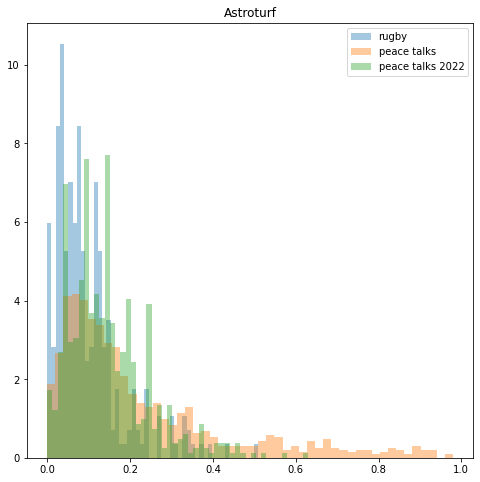

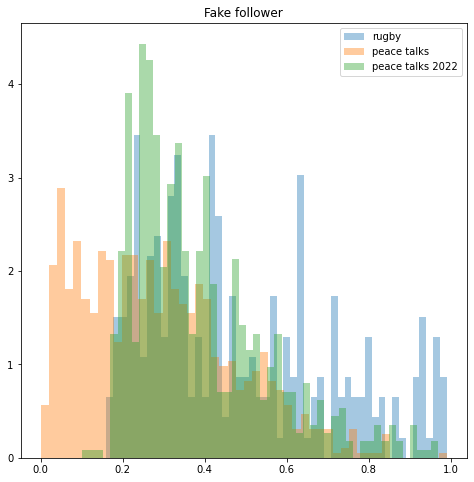

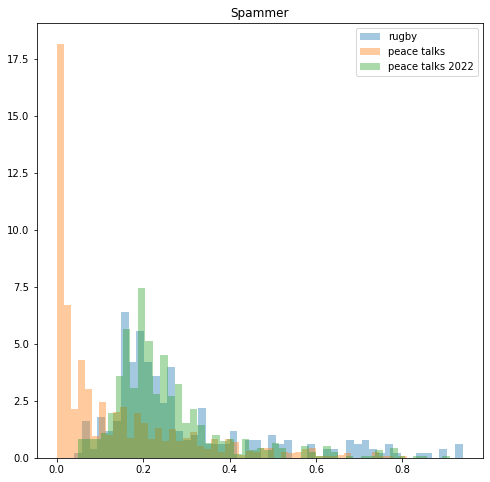

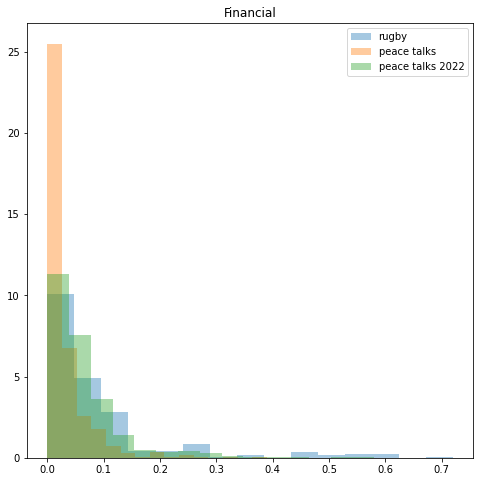

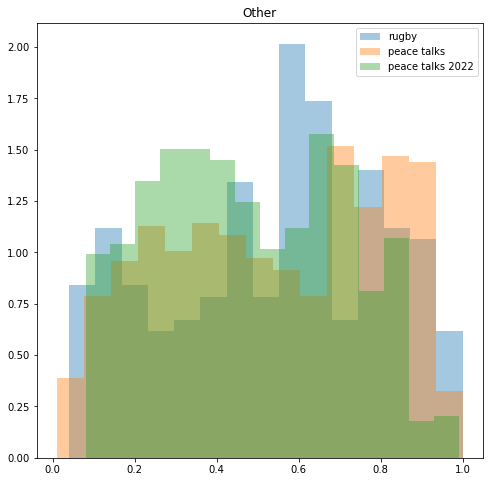

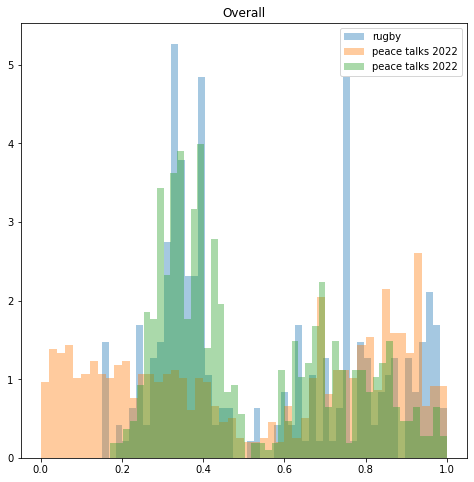

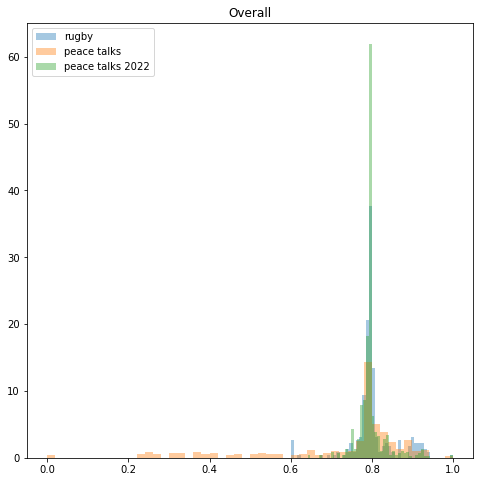

In [28]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_astroturf_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_astroturf_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.hist(score_astroturf_peace2022, 50, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Astroturf')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_fake_follower_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_fake_follower_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.hist(score_fake_follower_peace2022, 50, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Fake follower')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_spammer_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_spammer_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.hist(score_spammer_peace2022, 50, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Spammer')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_financial_rugby, 15, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_financial_peace, 15, alpha = 0.4, label = 'peace talks', density = True)
plt.hist(score_financial_peace2022, 15, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Financial')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_other_rugby, 15, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_other_peace, 15, alpha = 0.4, label = 'peace talks', density = True)
plt.hist(score_other_peace2022, 15, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Other')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_overall_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_overall_peace, 50, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.hist(score_overall_peace2022, 50, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Overall')
plt.legend()

fig, ax = plt.subplots(1,1, figsize = (8,8))
plt.hist(score_cap_rugby, 50, alpha = 0.4, label = 'rugby', density = True)
plt.hist(score_cap_peace, 50, alpha = 0.4, label = 'peace talks', density = True)
plt.hist(score_cap_peace2022, 50, alpha = 0.4, label = 'peace talks 2022', density = True)
plt.title('Overall')
plt.legend()


### Finding who is the most botlike:

In [29]:
tweets_en_df_peace2022

Unnamed: 0                   Datetime             Tweet Id  \
0    0           2022-03-27 20:47:04+00:00  1508183848177262593   
1    1           2022-03-27 20:45:47+00:00  1508183524687425536   
2    2           2022-03-27 20:05:37+00:00  1508173414569283591   
3    3           2022-03-27 20:01:27+00:00  1508172367863992329   
4    4           2022-03-27 19:54:38+00:00  1508170652972421121   
5    5           2022-03-27 19:53:04+00:00  1508170258942771201   
6    6           2022-03-27 19:21:45+00:00  1508162374758449152   
7    7           2022-03-27 19:18:14+00:00  1508161492616724483   
8    8           2022-03-27 19:16:45+00:00  1508161117482328070   
9    9           2022-03-27 19:12:40+00:00  1508160090477580291   
10   10          2022-03-27 19:12:21+00:00  1508160010819411979   
11   11          2022-03-27 18:58:21+00:00  1508156487071412233   
12   12          2022-03-27 18:11:20+00:00  1508144655757717513   
13   13          2022-03-27 17:52:34+00:00  1508139933319450627   
14   14          2022-03-27 15:45:01+00:00  1508107832088014852   
15   15          2022-03-27 14:22:58+00:00  1508087184368275469   
16   16          2022-03-27 14:10:01+00:00  1508083927042433036   
17   17          2022-03-27 13:58:25+00:00  1508081006988963840   
18   18          2022-03-27 13:33:20+00:00  1508074694800457730   
19   19          2022-03-27 12:57:34+00:00  1508065694537158663   
20   20          2022-03-27 12:53:28+00:00  1508064659915612160   
21   21          2022-03-27 12:53:20+00:00  1508064628391268361   
22   22          2022-03-27 09:20:29+00:00  1508011064222437376   
23   23          2022-03-27 07:48:59+00:00  1507988037149544451   
24   24          2022-03-27 07:47:56+00:00  1507987773315293188   
25   25          2022-03-27 07:02:28+00:00  1507976329874087937   
26   26          2022-03-27 03:46:08+00:00  1507926922331934720   
27   27          2022-03-27 02:47:12+00:00  1507912088852877317   
28   28          2022-03-27 00:34:33+00:00  1507878707913846788   
29   29          2022-03-27 00:14:49+00:00  1507873739152666624   
30   30          2022-03-27 23:54:39+00:00  1508231055773421578   
31   31          2022-03-27 23:53:31+00:00  1508230768362811392   
32   32          2022-03-27 23:45:07+00:00  1508228654593101825   
33   33          2022-03-27 23:40:59+00:00  1508227613164138497   
34   34          2022-03-27 23:16:57+00:00  1508221567448358918   
35   35          2022-03-27 23:16:02+00:00  1508221336564424707   
36   36          2022-03-27 23:10:21+00:00  1508219903748231168   
37   37          2022-03-27 23:08:42+00:00  1508219491032829952   
38   38          2022-03-27 22:59:18+00:00  1508217124010946560   
39   39          2022-03-27 22:58:42+00:00  1508216972257161216   
40   40          2022-03-27 22:56:02+00:00  1508216303915610117   
41   41          2022-03-27 22:55:32+00:00  1508216176748466180   
42   42          2022-03-27 22:53:17+00:00  1508215612253814785   
43   43          2022-03-27 22:43:36+00:00  1508213174734102535   
44   44          2022-03-27 22:39:47+00:00  1508212213462491141   
45   45          2022-03-27 22:38:21+00:00  1508211854253862915   
46   46          2022-03-27 22:35:29+00:00  1508211131596300291   
47   47          2022-03-27 22:32:57+00:00  1508210493781069824   
48   48          2022-03-27 22:31:28+00:00  1508210121024884742   
49   49          2022-03-27 22:28:48+00:00  1508209451135815685   
50   50          2022-03-27 22:28:10+00:00  1508209289340534793   
51   51          2022-03-27 22:27:34+00:00  1508209137544417284   
52   52          2022-03-27 22:24:42+00:00  1508208418393317381   
53   53          2022-03-27 22:20:20+00:00  1508207319204646921   
54   54          2022-03-27 22:18:20+00:00  1508206814772576257   
55   55          2022-03-27 22:08:58+00:00  1508204459733794818   
56   56          2022-03-27 22:07:58+00:00  1508204205529452548   
57   57          2022-03-27 22:07:18+00:00  1508204038961393664   
58   58          2022-03-27 22:06:03+00:00  15082037

In [31]:
tweets_en_df_rugby.loc[np.where((score_overall_rugby > 0.75))[0]]

Unnamed: 0  Unnamed: 0.1                   Datetime             Tweet Id  \
0    0           0             2022-03-18 21:33:45+00:00  1504934104973905927   
7    7           7             2022-03-18 18:37:11+00:00  1504889671754600448   
9    9           9             2022-03-18 17:49:19+00:00  1504877624698585092   
16   16          16            2022-03-18 07:55:15+00:00  1504728122322739203   
18   18          18            2022-03-18 02:19:05+00:00  1504643521952854019   
19   19          21            2022-03-18 01:26:04+00:00  1504630181667151873   
20   20          22            2022-03-18 00:25:43+00:00  1504614992787783682   
28   28          36            2022-03-18 17:41:17+00:00  1504875600896475141   
42   42          51            2022-03-19 22:12:45+00:00  1505306305057153024   
47   47          61            2022-03-19 21:52:03+00:00  1505301097514254347   
49   49          63            2022-03-19 21:51:16+00:00  1505300902659465217   
51   51          65            2022-03-19 21:48:55+00:00  1505300307701641221   
66   66          84            2022-03-19 20:58:30+00:00  1505287620775096320   
68   68          86            2022-03-19 20:57:24+00:00  1505287344957632519   
72   72          91            2022-03-19 20:49:24+00:00  1505285332652146696   
73   73          92            2022-03-19 20:48:45+00:00  1505285167761571842   
74   74          93            2022-03-19 20:47:45+00:00  1505284915637719041   
75   75          94            2022-03-19 20:47:11+00:00  1505284775539523587   
77   77          96            2022-03-19 20:29:53+00:00  1505280421357051905   
79   79          98            2022-03-19 20:28:02+00:00  1505279952501026816   
80   80          99            2022-03-19 20:27:59+00:00  1505279940798861322   
82   82          101           2022-03-19 20:27:15+00:00  1505279755901358081   
87   87          106           2022-03-19 20:03:50+00:00  1505273866008027142   
89   89          108           2022-03-19 19:53:16+00:00  1505271203275190273   
92   92          111           2022-03-19 19:25:19+00:00  1505264171801272325   
95   95          114           2022-03-19 19:14:02+00:00  1505261330395287566   
104  104         124           2022-03-19 13:42:03+00:00  1505177784330637313   
106  106         126           2022-03-19 11:11:27+00:00  1505139884507504641   
112  112         134           2022-03-19 07:36:23+00:00  1505085761179291649   
113  113         135           2022-03-19 01:51:24+00:00  1504998944291672064   
119  119         141           2022-03-19 22:51:36+00:00  1505316085121310720   
140  140         163           2022-03-19 22:05:23+00:00  1505304454362447873   
154  154         177           2022-03-19 21:53:25+00:00  1505301442793455623   
155  155         178           2022-03-19 21:52:33+00:00  1505301222038847492   
158  158         181           2022-03-19 21:51:26+00:00  1505300944266874880   
165  165         188           2022-03-19 21:14:39+00:00  1505291684481204224   
166  166         189           2022-03-19 21:03:14+00:00  1505288813358292993   
167  167         190           2022-03-19 20:55:26+00:00  1505286849090228224   
170  170         193           2022-03-19 20:45:19+00:00  1505284302472364036   
175  175         202           2022-03-19 19:52:22+00:00  1505270976434561025   
176  176         203           2022-03-19 19:32:47+00:00  1505266052019613700   
177  177         204           2022-03-19 18:43:07+00:00  1505253552855613440   
179  179         206           2022-03-19 16:19:45+00:00  1505217473649467398   
181  181         210           2022-03-19 12:59:26+00:00  1505167059000438786   
187  187         216           2022-03-19 09:16:10+00:00  1505110871642681354   
188  188         217           2022-03-19 09:07:54+00:00  1505108794937950209   
190  190         219           2022-03-19 07:27:36+00:00  1505083553591218179   
191  191         222           2022-03-19 22:07:36+00:00  1505305012402069504   
193  193         228           2022-

In [25]:
tweets_en_df_rugby.loc[np.where((score_overall_rugby > 0.75) & (score_self_declared_rugby < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
47   47          2022-03-18 18:44:27+00:00  1504891498172665856   
53   53          2022-03-18 17:44:28+00:00  1504876402805551108   
75   75          2022-03-18 14:00:45+00:00  1504820102566395905   
78   78          2022-03-18 13:36:01+00:00  1504813879460872192   
102  102         2022-03-18 08:23:49+00:00  1504735310084820995   
157  157         2022-03-19 23:44:41+00:00  1505329444306759681   
177  177         2022-03-19 22:55:08+00:00  1505316971294126081   
212  212         2022-03-19 22:22:36+00:00  1505308786952708101   
226  226         2022-03-19 22:14:44+00:00  1505306805529944066   
253  253         2022-03-19 22:06:05+00:00  1505304630393196552   
283  283         2022-03-19 21:59:28+00:00  1505302964059082752   
292  292         2022-03-19 21:57:16+00:00  1505302412478894100   
307  307         2022-03-19 21:54:17+00:00  1505301657948758022   
342  342         2022-03-19 21:50:36+00:00  1505300734509830145   
349  349         2022-03-19 21:50:01+00:00  1505300585104519177   
357  357         2022-03-19 21:48:42+00:00  1505300255956475908   
363  363         2022-03-19 21:46:17+00:00  1505299644837994503   
392  392         2022-03-19 21:26:47+00:00  1505294740580929547   
407  407         2022-03-19 21:16:09+00:00  1505292061511241729   
412  412         2022-03-19 21:12:33+00:00  1505291157496074249   
419  419         2022-03-19 21:03:48+00:00  1505288954219839498   
433  433         2022-03-19 20:57:34+00:00  1505287387966025731   
446  446         2022-03-19 20:52:28+00:00  1505286103330435072   
478  478         2022-03-19 20:40:15+00:00  1505283027450142723   
534  534         2022-03-19 20:06:17+00:00  1505274478925910019   
552  552         2022-03-19 19:58:00+00:00  1505272398173593614   
637  637         2022-03-19 18:43:23+00:00  1505253617154019331   
781  781         2022-03-20 07:11:06+00:00  1505441787439030273   
790  790         2022-03-20 05:50:36+00:00  1505421529122852866   
797  797         2022-03-20 03:59:14+00:00  1505393503395713027   

                                                                                                                                                                                                                                                                                                                      Text  \
47   France v England predictions and rugby union tips: Crunch time for Les Bleus - Racing Post https://t.co/V7V39E0Aj9                                                                                                                                                                                                      
53   France v England predictions and rugby union tips: Crunch time for Les Bleus - Racing Post https://t.co/Z7o6KxMO9b                                                                                                                                                                                                      
75   @SixNationsRugby Most likely. I guarantee if England beat France, Ireland will slip up against Scotland and they’ll win it anyway. Much as I love Ireland, it’s not likely they’ll take it                                                                                                                              
78   @SixNationsRugby @EnglandRugby @FranceRugby The Premiership teams provide a landslide of tries ever weekend, exciting attacking play, skilful players and Eddie Jones’s team cannot buy a try. Go figure! What’s the betting that after England lose to France that Fast Eddie blames the Premiership structure etc..   
102  Preview: France v England via @SixNationsRugby https://t.co/iWLaYmoLIF                                                                                                                                                                                                                                                  
157  Rugby-Superb F

In [26]:
tweets_en_df_peace.loc[np.where((score_overall_peace > 0.75) & (score_self_declared_peace < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
11   11          2022-03-27 23:08:53+00:00  1508219534611730435   
19   19          2022-03-27 22:41:13+00:00  1508212574374047751   
20   20          2022-03-27 22:39:53+00:00  1508212240171905028   
41   41          2022-03-27 22:09:00+00:00  1508204465102499851   
42   42          2022-03-27 22:08:53+00:00  1508204437088747529   
48   48          2022-03-27 22:03:10+00:00  1508202998194974724   
50   50          2022-03-27 22:00:21+00:00  1508202290720694277   
51   51          2022-03-27 21:59:58+00:00  1508202194738290688   
69   69          2022-03-27 21:17:11+00:00  1508191425598349312   
88   88          2022-03-27 20:45:27+00:00  1508183442294419459   
96   96          2022-03-27 20:26:17+00:00  1508178616760377348   
139  139         2022-03-27 19:11:24+00:00  1508159770070601728   
214  214         2022-03-27 16:52:03+00:00  1508124705106001926   
223  223         2022-03-27 16:38:50+00:00  1508121379064930304   
224  224         2022-03-27 16:38:25+00:00  1508121271984349197   
237  237         2022-03-27 16:12:05+00:00  1508114644241690625   
254  254         2022-03-27 15:44:36+00:00  1508107730258640899   
256  256         2022-03-27 15:42:20+00:00  1508107156704403457   
257  257         2022-03-27 15:38:19+00:00  1508106149681319945   
281  281         2022-03-27 14:55:35+00:00  1508095391451041796   
283  283         2022-03-27 14:52:13+00:00  1508094546932113416   
292  292         2022-03-27 14:35:03+00:00  1508090226090020865   
295  295         2022-03-27 14:29:57+00:00  1508088942406639620   
315  315         2022-03-27 13:50:06+00:00  1508078914807209985   
316  316         2022-03-27 13:47:01+00:00  1508078136847593475   
323  323         2022-03-27 13:18:34+00:00  1508070976457687041   
340  340         2022-03-27 12:47:35+00:00  1508063179787714560   
341  341         2022-03-27 12:46:24+00:00  1508062884345139210   
346  346         2022-03-27 12:31:20+00:00  1508059092383903745   
354  354         2022-03-27 12:01:09+00:00  1508051495811379200   
355  355         2022-03-27 12:00:06+00:00  1508051230496419840   
356  356         2022-03-27 12:00:03+00:00  1508051219113132034   
359  359         2022-03-27 11:58:05+00:00  1508050723522576384   
365  365         2022-03-27 11:47:02+00:00  1508047943869284354   
372  372         2022-03-27 10:42:11+00:00  1508031623857647619   
408  408         2022-03-27 07:04:30+00:00  1507976842388688900   
433  433         2022-03-27 05:01:36+00:00  1507945912303484929   
435  435         2022-03-27 04:54:25+00:00  1507944105216995337   
446  446         2022-03-27 03:21:59+00:00  1507920842679734285   
451  451         2022-03-27 03:00:52+00:00  1507915527456530437   
452  452         2022-03-27 03:00:01+00:00  1507915313454940161   
457  457         2022-03-27 02:47:12+00:00  1507912088852877317   
476  476         2022-03-27 00:38:33+00:00  1507879714400063490   
492  492         2022-03-28 23:45:00+00:00  1508591012297412609   
528  528         2022-03-28 23:20:54+00:00  1508584946297974786   
537  537         2022-03-28 23:17:19+00:00  1508584045776715786   
538  538         2022-03-28 23:17:04+00:00  1508583983499689990   
541  541         2022-03-28 23:16:12+00:00  1508583765576060930   
546  546         2022-03-28 23:11:29+00:00  1508582577245937666   
548  548         2022-03-28 23:09:06+00:00  1508581978232160256   
549  549         2022-03-28 23:08:55+00:00  1508581933499965447   
551  551         2022-03-28 23:06:03+00:00  1508581212792799232   
573  573         2022-03-28 22:48:25+00:00  1508576774409662472   
575  575         2022-03-28 22:47:04+00:00  1508576434876399617   
580  580         2022-03-28 22:40:14+00:00  1508574715283185664   
614  614         2022-03-28 22:13:47+00:00  1508568056758374406   
616  616         2022-03-28 22:12:07+00:00  1508567638657613825   
638  638         2022-03-28 22:00:08+00:00  1508564621233639424   
641  641         2022-03-28 21:57:38+00:00  15085639

In [11]:
tweets_en_df_rugby.loc[np.where((score_overall_rugby > 0.75) & (score_self_declared_rugby < 0.6) & (score_other_rugby < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
307  307         2022-03-19 21:54:17+00:00  1505301657948758022   
357  357         2022-03-19 21:48:42+00:00  1505300255956475908   
392  392         2022-03-19 21:26:47+00:00  1505294740580929547   
419  419         2022-03-19 21:03:48+00:00  1505288954219839498   

                                                                                                                                                                                                                                                 Text  \
307  79 min\n\nFrance deservedly about to win the Grand Slam\n\nWhat are the commentator's final thoughts?\n\n"What do we think England can take from this game?"\n\nFFS! 🤔\n\nBest team in the 6 Nations.\n\nCongratulations @FranceRugby\n #FRAvENG   
357  @UTDJack10 @FranceRugby I totally agree though. England are pretty shit at the moment                                                                                                                                                              
392  @FranceRugby England fan here, it's a joy to watch this french team                                                                                                                                                                                
419  @ScotsmanPaddy The commentary sums up just why I dislike having to view the rugby on ITV. France playing England off the park and all the pundits comments are o me miserum.                                                                       

          Username  Like Count             Display Name Language  Astroturf  \
307  MikeFealey     1           Mike Fealey #JohnsonOut  en       0.85        
357  Digby_sdb      0           Sam Bolton               en       0.06        
392  Digby_sdb      11          Sam Bolton               en       0.06        
419  markrowantree  2           markrowantree            en       0.77        

     Fake follower  Financial  Other  Overall  Self declared  Spammer  \
307  0.22           0.10       0.41   0.85     0.02           0.02      
357  0.78           0.24       0.53   0.78     0.56           0.54      
392  0.78           0.24       0.53   0.78     0.56           0.54      
419  0.16           0.03       0.37   0.77     0.03           0.01      

          Cap  
307  0.833918  
357  0.807604  
392  0.807604  
419  0.805478

In [12]:
tweets_en_df_peace.loc[np.where((score_overall_peace > 0.75) & (score_self_declared_peace < 0.6) & (score_other_peace < 0.6))[0]]

Unnamed: 0                   Datetime             Tweet Id  \
11   11          2022-03-27 23:08:53+00:00  1508219534611730435   
19   19          2022-03-27 22:41:13+00:00  1508212574374047751   
42   42          2022-03-27 22:08:53+00:00  1508204437088747529   
88   88          2022-03-27 20:45:27+00:00  1508183442294419459   
139  139         2022-03-27 19:11:24+00:00  1508159770070601728   
223  223         2022-03-27 16:38:50+00:00  1508121379064930304   
224  224         2022-03-27 16:38:25+00:00  1508121271984349197   
237  237         2022-03-27 16:12:05+00:00  1508114644241690625   
254  254         2022-03-27 15:44:36+00:00  1508107730258640899   
256  256         2022-03-27 15:42:20+00:00  1508107156704403457   
283  283         2022-03-27 14:52:13+00:00  1508094546932113416   
292  292         2022-03-27 14:35:03+00:00  1508090226090020865   
295  295         2022-03-27 14:29:57+00:00  1508088942406639620   
315  315         2022-03-27 13:50:06+00:00  1508078914807209985   
323  323         2022-03-27 13:18:34+00:00  1508070976457687041   
340  340         2022-03-27 12:47:35+00:00  1508063179787714560   
341  341         2022-03-27 12:46:24+00:00  1508062884345139210   
346  346         2022-03-27 12:31:20+00:00  1508059092383903745   
446  446         2022-03-27 03:21:59+00:00  1507920842679734285   
451  451         2022-03-27 03:00:52+00:00  1507915527456530437   
538  538         2022-03-28 23:17:04+00:00  1508583983499689990   
541  541         2022-03-28 23:16:12+00:00  1508583765576060930   
551  551         2022-03-28 23:06:03+00:00  1508581212792799232   
706  706         2022-03-28 21:18:21+00:00  1508554109124763658   
786  786         2022-03-28 20:43:46+00:00  1508545402504728586   
810  810         2022-03-28 20:28:47+00:00  1508541633997901826   
830  830         2022-03-28 20:16:15+00:00  1508538477595529220   
892  892         2022-03-28 19:50:46+00:00  1508532068002713607   
927  927         2022-03-28 19:33:37+00:00  1508527751103406089   
946  946         2022-03-28 19:22:39+00:00  1508524991108640771   
955  955         2022-03-28 19:17:31+00:00  1508523697832964096   

                                                                                                                                                                                                                                                                                                            Text  \
11   Trump Wouldn't Be 'Capable' Of Ukraine Peace Talks With Moscow, Says John Bolton\nhttps://t.co/pp1bB0ij4E                                                                                                                                                                                                     
19   Current reporting, "Russia and Ukraine will hold another round of in-person peace talks in Turkey starting tomorrow, the head of Kyiv’s delegation says". https://t.co/PS1qXam8wa                                                                                                                             
42   Trump Wouldn’t Be ‘Capable’ Of Ukraine Peace Talks With Moscow, Says John Bolton\nhttps://t.co/sGqHNK2y5E                                                                                                                                                                                                     
88   Russia-Ukraine live updates: Agreement reached on new round of in-person peace talks - ABC News - https://t.co/hWCvyCBrf0 via @ABC                                                                                                                                                                            
139  Lets see, as one of the elitist DC "Smart ppl", I'm sure you realize #Puntin invaded #Ukraine under Obama &amp; #JoeBiden -NOT #Trump ... would not be 'capable' of holding Ukraine-Russia peace talks, says his former national security adviser John Bolton https://t.co/5yrMuN508E                         
223  Trump W